<a href="https://colab.research.google.com/github/umair-hassan2/paligemma-3b-finetuning/blob/master/valorant_paligemma_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers bitsandbytes peft
# Downgrading for issue: https://github.com/mahmoodlab/HEST/issues/110
!pip install datasets==2.16.0
!pip install huggingface_hub
!pip install wandb

In [ ]:
import torch
import cv2
import re
import wandb

from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType
from PIL import ImageDraw
from IPython.display import display

from transformers import Trainer
from transformers import TrainingArguments
from transformers import BitsAndBytesConfig
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration
from huggingface_hub import snapshot_download

In [ ]:
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: umairpu24 (umairpu24-pucit-punjab-university-college-of-information) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
%env WANDB_PROJECT=valorant_paligemma2_fine_tuning
%env WANDB_LOG_MODEL=end

env: WANDB_PROJECT=valorant_paligemma2_fine_tuning
env: WANDB_LOG_MODEL=end


In [ ]:
# Dataset classes
classes = ['dropped spike', 'enemy', 'planted spike', 'teammate']

In [ ]:
def visualize(example):
  image = example['image']
  category_idx = example['objects']['category'][0]
  display(image)
  category = classes[category_idx]
  print(f"Object Category: {category}")

### Format training data
- Training data is in dictionary format which contains image and relevant metadata
- Metadata include bounding box coordinates `[x, y, width, height]` (COCO format) and object category `['dropped spike', 'enemy', 'planted spike', 'teammate']`
- convert this to formal representation `<locXXXX><locXXXX><locXXXX><locXXXX> [CLASS]`

In [ ]:
def coco_to_xyxy(coordinates):
  x, y, width, height = coordinates
  x1, y1 = x, y
  x2 = x1 + width
  y2 = y1 + height
  return [x1, y1, x2, y2]

In [ ]:
def paligemma_decoded_format(encoded_bbox):
  """
  This method decodes Paligemma specific format <locXXXX><locXXXX><locXXXX><locXXXX> [CLASS]; <locXXXX><locXXXX><locXXXX><locXXXX> [CLASS] ; ...
  into XYXY format [x1, y1, x2, y2] where each values represnts corner points of bounding box

  Decodes string like "<loc0005><loc0234><loc0450><loc0678> cat"
  into
  [
    {
      'bbox': [5, 234, 450, 678],
      'label': cat
    }
  ]
  """
  pattern = r"<loc(\d{4})><loc(\d{4})><loc(\d{4})><loc(\d{4})>\s+([^;]+)"
  matches = re.findall(pattern, encoded_bbox)
  decoded_strs = []
  for c_match in matches:
    if len(c_match) < 5:
      raise ValueError("Not Enough <locXXXX> tokens found")
    coords = list(map(lambda x: int(x)/1024, c_match[:4]))
    label = c_match[4].strip()
    decoded_strs.append({
        'label': label,
        'bbox': coords
    })

  return decoded_strs

### Upload dataset to hugging face for easier access

In [ ]:
# hugging face login
from huggingface_hub import notebook_login
notebook_login()
!git config --global credential.helper store

## Load custom Paligemma format encoded dataset from hugging face

In [ ]:
dataset_key = "umairhassan02/paligemma-valorant-object-detection-transformed"
valorant_ds = load_dataset(dataset_key)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/6927 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1983 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/988 [00:00<?, ? examples/s]

In [ ]:
valorant_ds

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects', 'paligemma_label'],
        num_rows: 6927
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects', 'paligemma_label'],
        num_rows: 1983
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects', 'paligemma_label'],
        num_rows: 988
    })
})

In [ ]:
train_split = valorant_ds['train']
test_split = valorant_ds['test']
valid_split = valorant_ds['validation']
print(f"Train split size: {len(train_split)}")
print(f"Validation split size: {len(valid_split)}")
print(f"Test split size: {len(test_split)}")

Train split size: 6927
Validation split size: 1983
Test split size: 988


In [ ]:
train_split[0]

{'image_id': 3947,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=416x416>,
 'width': 416,
 'height': 416,
 'objects': {'id': [4083],
  'area': [3718],
  'bbox': [[147.0, 201.0, 33.5, 111.0]],
  'category': [1]},
 'paligemma_label': '<loc0362><loc0495><loc0444><loc0768> enemy'}

In [ ]:
# Verify decoder
decoded_strs = paligemma_decoded_format(valorant_ds['train'][0]['paligemma_label'])
decoded_bboxes = [d['bbox'] for d in decoded_strs]
decoded_labels = [d['label'] for d in decoded_strs]

original_bboxes = valorant_ds['train'][0]['objects']
norm_config = [valorant_ds['train'][0]['width'], valorant_ds['train'][0]['height']]
unormalized_bboxes = [[x * norm_config[idx % 2] for idx, x in enumerate(bbox)] for bbox in decoded_bboxes]
print(f"DECODED BBOXES: {unormalized_bboxes}")
print(f"DECODED LABEL: {decoded_labels}")
print(f"ORIGINAL BBOXES: {coco_to_xyxy(original_bboxes['bbox'][0])}")
print(f"ORIGINAL LABEL: {classes[original_bboxes['category'][0]]}")

DECODED BBOXES: [[147.0625, 201.09375, 180.375, 312.0]]
DECODED LABEL: ['enemy']
ORIGINAL BBOXES: [147.0, 201.0, 180.5, 312.0]
ORIGINAL LABEL: enemy


## MODEL INFERENCE

In [ ]:
# Ref: https://huggingface.co/google/paligemma-3b-pt-224
MODEL_ID = "google/paligemma-3b-pt-224"

In [ ]:
pretrained_processor= PaliGemmaProcessor.from_pretrained(MODEL_ID)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

In [ ]:
snapshot_download(repo_id=MODEL_ID)

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

'/root/.cache/huggingface/hub/models--google--paligemma-3b-pt-224/snapshots/35e4f46485b4d07967e7e9935bc3786aad50687c'

In [ ]:
pretrained_model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
def draw_bboxes(image, bbox_cords, labels):
  draw = ImageDraw.Draw(image)

  # pixel values are normalized in range [0,1]
  # multiple these values by image height and width to get actual pixel coordinates
  W, H = image.size
  for bbox, label in zip(bbox_cords, labels):
    x1, y1, x2, y2 = bbox
    draw.rectangle([x1 * W, y1 * H, x2 * W, y2 * H], width=3)
    draw.text((x1 * W, y1 * H), text=label, fill=(255, 0, 0))
  return image

In [ ]:
# Inference function
def process_image_text(image, text):
  inputs = pretrained_processor(text=text, images=image, return_tensors="pt")
  try:
    print("MODEL INFERENCE METHOD CALLED...")
    output = pretrained_model.generate(**inputs, max_new_tokens=100)

    print("MODEL RESPONSE GENERATED")
    print(output)

    decoded_output = pretrained_processor.decode(output[0], skip_special_tokens=True)
    decoded_strs = paligemma_decoded_format(decoded_output)
    if decoded_strs:
      decoded_bboxes = [d['bbox'] for d in decoded_strs]
      decoded_labels = [d['label'] for d in decoded_strs]
      annotated_image = draw_bboxes(image, decoded_bboxes, decoded_labels)

      metadata = "\n".join([f"Label: {label}, Coordinates: {coords}" for label, coords in zip(decoded_labels, decoded_bboxes)])
      return annotated_image, metadata
    else:
      raise Exception("No bounding box detected by model")
  except Exception as e:
    print("Error occured during model inference")
    print(e)
    return image, ""

## PRETRAINED MODEL TESTING

In [ ]:
test_sample = valorant_ds['test'][10]

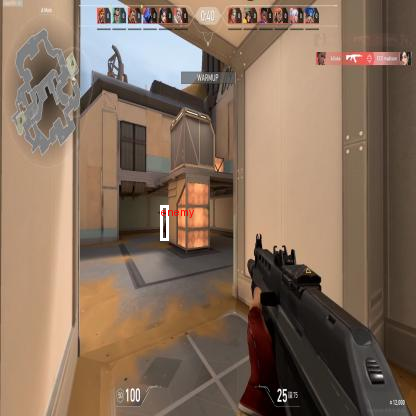

Label: enemy


In [ ]:
# Ground Truth
decoded_strs = paligemma_decoded_format(test_sample['paligemma_label'])
decoded_bboxes = [d['bbox'] for d in decoded_strs]
decoded_labels = [d['label'] for d in decoded_strs]
annotated_image = draw_bboxes(test_sample['image'], decoded_bboxes, decoded_labels)
display(annotated_image)
for category in decoded_labels:
  print(f"Label: {category}")

In [ ]:
# Pretrained model prediction
annotated_image, metadata = process_image_text(test_sample['image'], "detect enemy")

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


MODEL INFERENCE METHOD CALLED...
MODEL RESPONSE GENERATED
tensor([[257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 25

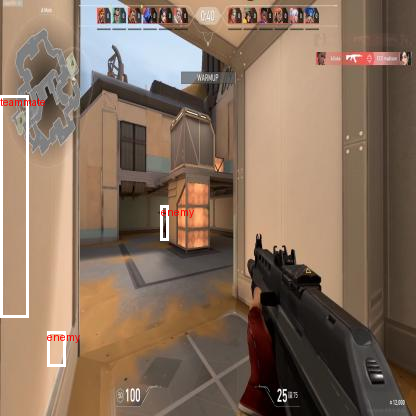

Label: enemy, Coordinates: [0.11328125, 0.796875, 0.1572265625, 0.8818359375]


In [ ]:
display(annotated_image)
print(metadata)

## Fine tuning PaliGemma Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
DTYPE = torch.bfloat16

Using cuda device


In [ ]:
def collate_fn(examples):
  texts = [f"<image>detect " + ", ".join([classes[int(idx)] for idx in example["objects"]["category"]]) for example in examples]
  labels= [example['paligemma_label'] for example in examples]
  images = [example["image"].convert("RGB") for example in examples]
  tokens = pretrained_processor(text=texts, images=images, suffix=labels,
                    return_tensors="pt", padding="longest")

  tokens = tokens.to(DTYPE).to(device)
  return tokens

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
bnb_config

BitsAndBytesConfig {
  "_load_in_4bit": true,
  "_load_in_8bit": false,
  "bnb_4bit_compute_dtype": "bfloat16",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "nf4",
  "bnb_4bit_use_double_quant": false,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": true,
  "load_in_8bit": false,
  "quant_method": "bitsandbytes"
}

In [ ]:
lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)
lora_config

LoraConfig(task_type='CAUSAL_LM', peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, inference_mode=False, r=8, target_modules={'v_proj', 'k_proj', 'gate_proj', 'down_proj', 'up_proj', 'o_proj', 'q_proj'}, exclude_modules=None, lora_alpha=8, lora_dropout=0.0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, use_qalora=False, qalora_group_size=16, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False, target_parameters=None)

In [ ]:
# Using QLoRA
model = PaliGemmaForConditionalGeneration.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map={"":0}
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 11,298,816 || all params: 2,934,765,296 || trainable%: 0.3850


In [ ]:
args = TrainingArguments(
    num_train_epochs=2,
    remove_unused_columns=False,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=2,
    learning_rate=1e-5,
    weight_decay=1e-6,
    adam_beta2=0.999,
    logging_steps=100,
    optim="adamw_torch",
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=1,
    output_dir="valorant/paligemma2_finetuned",
    bf16=True,
    report_to=["wandb"],
    run_name="valorant-paligemma2-finetuning-qlora",
    dataloader_pin_memory=False,
    eval_strategy="steps",
    eval_steps=500
)

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_split,
    eval_dataset=valid_split,
    data_collator=collate_fn
)

In [ ]:
trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss
500,3.193700,3.176549


TrainOutput(global_step=866, training_loss=3.3805773693199246, metrics={'train_runtime': 3389.7386, 'train_samples_per_second': 4.087, 'train_steps_per_second': 0.255, 'total_flos': 5.365601368417997e+16, 'train_loss': 3.3805773693199246, 'epoch': 2.0})

In [ ]:
trainer.push_to_hub("umairhassan02/paligemma-valorant-finetuned-qlora")

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...finetuned/adapter_model.safetensors:   0%|          | 61.5kB / 45.3MB            

  ...igemma2_finetuned/training_args.bin:   1%|1         |  72.0B / 5.78kB            

CommitInfo(commit_url='https://huggingface.co/umairhassan02/paligemma2_finetuned/commit/358a1bd28c626c03f70c99909661ea8fd3ca7cf7', commit_message='umairhassan02/paligemma-valorant-finetuned-qlora', commit_description='', oid='358a1bd28c626c03f70c99909661ea8fd3ca7cf7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/umairhassan02/paligemma2_finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='umairhassan02/paligemma2_finetuned'), pr_revision=None, pr_num=None)